In [50]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
import gensim
from gensim.models import Word2Vec, KeyedVectors
import re
from nltk import re
from helpers import regex, utils
from keras.datasets import imdb
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, TimeDistributed
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional, Conv1D, MaxPooling1D, Flatten
from keras.models import Model

# 1. Load and Explore the Training and Test data

In [3]:
train_df = pd.read_csv('train.csv')
train_df[train_df['threat']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
600,0199d6af27b715f3,I'm also a sock puppet of this account...SUPRI...,1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when ...",1,0,1,1,1,0
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1


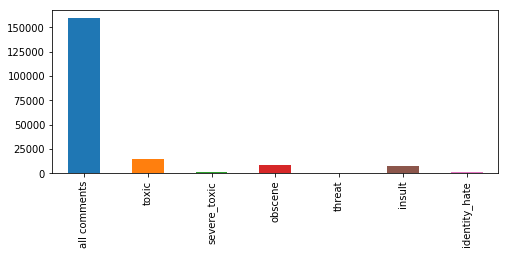

In [4]:
train_df['all comments']=1
plt.figure(figsize=(8,3))
train_df[['all comments','toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum().plot.bar()
plt.show()

Looks like only 10% or less of the overall samples are negative which seems reflective of the true incident rate of such comments on online discussion forums

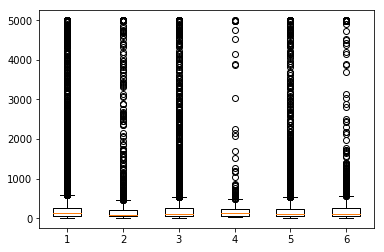

In [5]:
plt.subplots()
plt.boxplot([train_df[train_df['toxic']==1]['comment_text'].apply(len),
             train_df[train_df['severe_toxic']==1]['comment_text'].apply(len),
            train_df[train_df['obscene']==1]['comment_text'].apply(len),
            train_df[train_df['threat']==1]['comment_text'].apply(len),
            train_df[train_df['insult']==1]['comment_text'].apply(len),
            train_df[train_df['identity_hate']==1]['comment_text'].apply(len)])
plt.show()

90th percentile length of comments within each category of toxicity


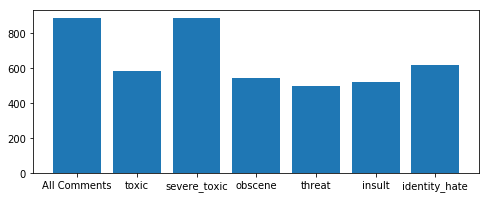

In [6]:
print('90th percentile length of comments within each category of toxicity')
plt.figure(figsize=(8,3))
plt.bar(x=['All Comments','toxic','severe_toxic','obscene','threat','insult','identity_hate'],height=[
    np.percentile(train_df['comment_text'].apply(len),90),
    np.percentile(train_df[train_df['toxic']==1]['comment_text'].apply(len),90),
             np.percentile(train_df[train_df['severe_toxic']==1]['comment_text'].apply(len),90),
            np.percentile(train_df[train_df['obscene']==1]['comment_text'].apply(len),90),
            np.percentile(train_df[train_df['threat']==1]['comment_text'].apply(len),90),
            np.percentile(train_df[train_df['insult']==1]['comment_text'].apply(len),90),
            np.percentile(train_df[train_df['identity_hate']==1]['comment_text'].apply(len),90)
])
plt.show()

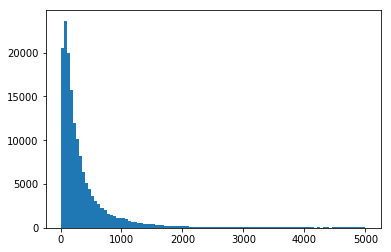

In [7]:
plt.subplots()
plt.hist(train_df['comment_text'].apply(len), bins=100)
plt.show()

Longest comment is 5000 words long while the shortest is 6 words, with and average length of 394 words. 90th percentile length of comments in each category is less than 900 words. With severly toxic comments being the longest.

In [8]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
print('90th percentile length of the test comments: '+str(np.percentile(test_df['comment_text'].apply(len),90)))

90th percentile length of the test comments: 804.0


In [10]:
tweet_df = pd.read_csv('player_tweets.csv')
tweet_df = tweet_df[tweet_df['tweet'].notna()]
tweet_df['comment_text'] = tweet_df['tweet']
tweet_df.head()

,Unnamed: 0,id,tweet,is_retweet,len,date,source,likes,retweets,screenname,followers,sentiment,comment_text
0,0,8.736000e+17,@ekelly_28 😂😂😂😂😂😂,False,17,2017-06-10 17:57:10,Echofon,1,0,hairston_pj,3149,0,@ekelly_28 😂😂😂😂😂😂
1,1,8.496350e+17,@CountryAssDot 😂😂😂😂😂,False,20,2017-04-05 14:49:22,Echofon,0,1,hairston_pj,3149,0,@CountryAssDot 😂😂😂😂😂
2,2,8.496330e+17,@CountryAssDot lol nah it ain't that serious. ...,False,128,2017-04-05 14:40:52,Echofon,1,1,hairston_pj,3149,1,@CountryAssDot lol nah it ain't that serious. ...
3,3,8.496320e+17,@CountryAssDot just another bitter Duke fan wa...,False,89,2017-04-05 14:39:06,Echofon,4,1,hairston_pj,3149,1,@CountryAssDot just another bitter Duke fan wa...
4,4,8.496320e+17,"@CountryAssDot actually, no. Someone told me I...",False,107,2017-04-05 14:38:30,Echofon,1,1,hairston_pj,3149,0,"@CountryAssDot actually, no. Someone told me I..."


# 2. Normalize and tokenize test and training comments

##### Regular Pre-processing

In [11]:
#EMOTICONS
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [12]:
def Preprocessor(data_df):
    text_LIST = []
    for i in range(0,len(data_df)):
        text = data_df['comment_text'].iloc[i]

        #Remove urls
        text = re.sub(pattern=regex.get_url_patern(), repl='', string=text)

        #Remove punctuations
        text = re.sub(pattern=regex.get_mentions_pattern(), repl='', string=text)

        #remove_twitter_reserved_words
        #text = re.sub(pattern=regex.get_twitter_reserved_words_pattern(), repl='', string=text)

        #remove_single_letter_words
        text = re.sub(pattern=regex.get_single_letter_words_pattern(), repl='', string=text)

        #remove_blank_spaces
        text = re.sub(pattern=regex.get_blank_spaces_pattern(), repl=' ', string=text)

        #emoji patter
        text = emoji_pattern.sub(r'', text)
        
        text_LIST.append(text)
    data_df['comment_text'] = text_LIST
    
    return data_df

In [13]:
train_df = Preprocessor(train_df)
tweet_df = Preprocessor(tweet_df)
test_df = Preprocessor(test_df)

Looking at the Penn Treebank tokenizer and Tweet Tokenizer to identify the best option for this exersise

In [14]:
lem = WordNetLemmatizer()
numbers = '1234567890'
exclusion = punctuation+numbers
exclusion = str.replace(exclusion,"'","")
stop_words=set(stopwords.words("english"))
stop_words.add("'")
stop_words.add("I")
stop_words.add("i")
stop_words.add("RT")
stop_words.add("rt")
stop_words.add("…")
stop_words.add("’")
stop_words.add("“")
stop_words.add("”")
stop_words.add("br")

In [15]:
def myTokenizer(data_df, type_of_tok):
    tokenizer = TweetTokenizer()
    data_tokens = []
    for i in range(0,len(data_df)):
        if type_of_tok == "TweetTokenizer":
            #print(data_df['comment_text'].iloc[i])
            tok = tokenizer.tokenize(data_df['comment_text'].iloc[i].translate ({ord(c): " " for c in exclusion}))
        elif type_of_tok == "WordTokenizer":
            tok = nltk.tokenize.word_tokenize(data_df['comment_text'].iloc[i].translate ({ord(c): " " for c in exclusion}))
        tok = [lem.lemmatize(tok_ITEM).lower() for tok_ITEM in tok if tok_ITEM not in stop_words]
        
        data_tokens.append(tok)
    len_tokens = []
    for i in range(0,len(data_tokens)):
        len_tokens.append([len(data_tokens[i]),data_tokens[i]])
    len_data_tokens_df = pd.DataFrame(len_tokens,columns=['length','tokens'])
    return pd.concat([data_df, len_data_tokens_df], axis=1, sort=False)

##### Tokenizing Training Data

In [17]:
train_df_tt = myTokenizer(train_df, "TweetTokenizer")
train_df_tt = train_df_tt[train_df_tt['length']!=0]
train_df_tt['length'].describe()

count    159532.000000
mean         36.871969
std          57.864888
min           1.000000
25%           9.000000
50%          19.000000
75%          40.000000
max        1353.000000
Name: length, dtype: float64

In [18]:
train_df_wt = myTokenizer(train_df, "WordTokenizer")
train_df_wt = train_df_wt[train_df_wt['length']!=0]
train_df_wt['length'].describe()

count    159532.000000
mean         37.031555
std          57.973653
min           1.000000
25%           9.000000
50%          19.000000
75%          40.000000
max        1353.000000
Name: length, dtype: float64

It looks like Twitter tokenizer results in a slightly lower # of avg of elements per commemt. Also, it seems to be doing a better job with some really long comments with lot of repeating charaters/ words/ punctuations.
Let's look at the most common 60 elements from each tokenizer

In [19]:
print("Original comment sample prior to pre-processing\n")
print(train_df_tt['comment_text'].iloc[0])
print("\n\nPre-processed comment tokens\n")
print(train_df_tt['tokens'].iloc[0])

Original comment sample prior to pre-processing

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren' vandalisms, just closure on some GAs after voted at New York Dolls FAC. And please don' remove the template from the talk page since ' retired now.89.205.38.27


Pre-processed comment tokens

['explanation', 'why', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'they', 'vandalism', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retired']


##### Tokenizing Test Data

In [20]:
test_df_tt = myTokenizer(test_df, "TweetTokenizer")
test_df_tt = test_df_tt[test_df_tt['length']!=0]
test_df_tt['length'].describe()

count    152990.000000
mean         34.918230
std          66.595534
min           1.000000
25%           8.000000
50%          17.000000
75%          36.000000
max        4556.000000
Name: length, dtype: float64

##### Tokenizing Tweet Data

In [21]:
tweet_df_tt = myTokenizer(tweet_df, "TweetTokenizer")
tweet_df_tt = tweet_df_tt[tweet_df_tt['length']!=0]
tweet_df_tt = tweet_df_tt[tweet_df_tt.notna()]
tweet_df_tt['length'].describe()

count    926702.000000
mean          6.481227
std           4.509877
min           1.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          55.000000
Name: length, dtype: float64

In [22]:
def showFreqDist(data_tokens):
    full_data_tokens = []
    for data_tokens_ITEM in data_tokens:
        full_data_tokens.extend(data_tokens_ITEM)
    fdist = FreqDist(full_data_tokens)
    plt.figure(figsize=(20,5))
    fdist.plot(60,cumulative=False)
    plt.show()
    return fdist

##### Most common elements of Twitter tokenizer results

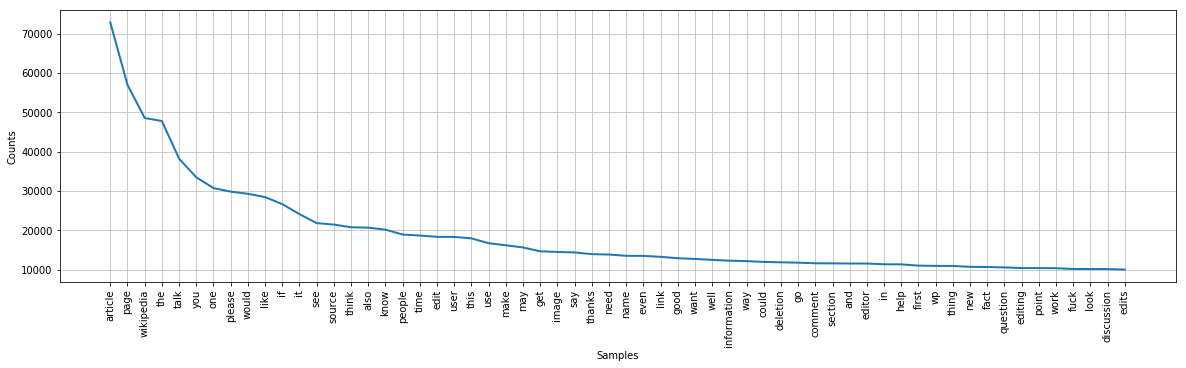

In [23]:
fdist_train_tt = showFreqDist(train_df_tt['tokens'])

##### Most common elements of regular word tokenizer results

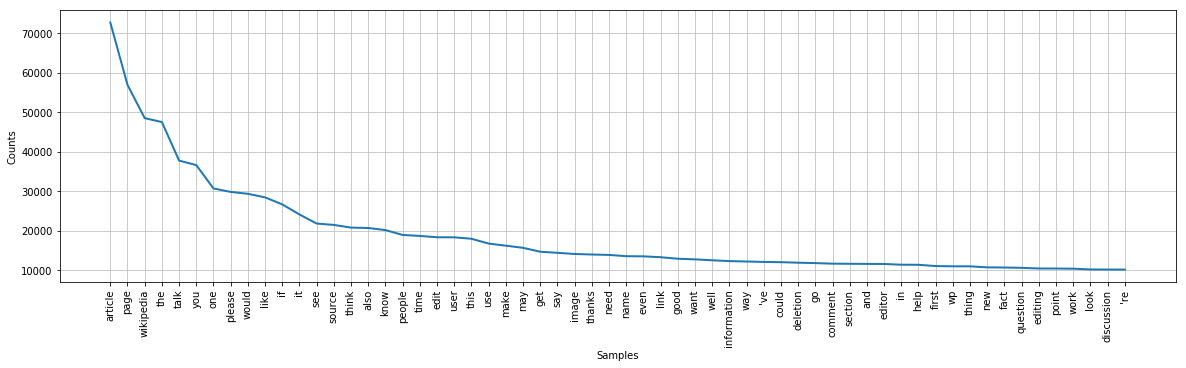

In [24]:
fdist_train_wt = showFreqDist(train_df_wt['tokens'])

##### Most common elements from the twitter data with Twitter Tokenizer

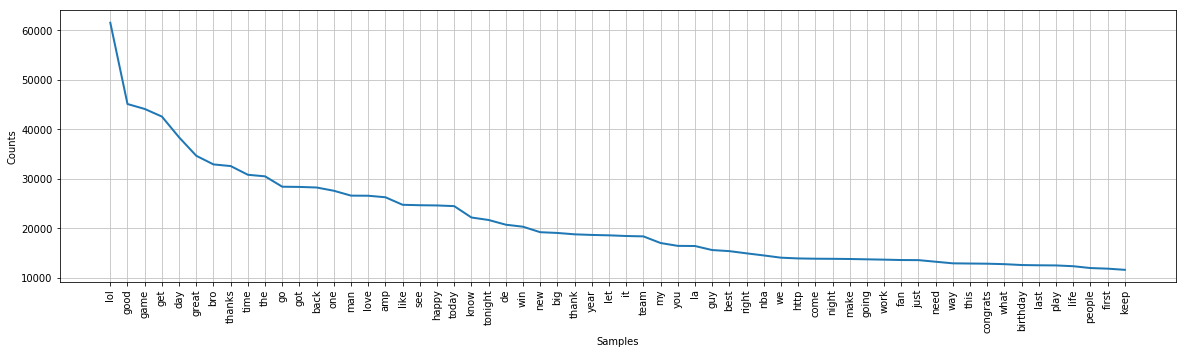

In [25]:
tweet_df_tt = tweet_df_tt[tweet_df_tt['tokens'].notna()]
fdist_tweet_tt = showFreqDist(tweet_df_tt['tokens'])

##### Most common elements from the test data with Twitter Tokenizer

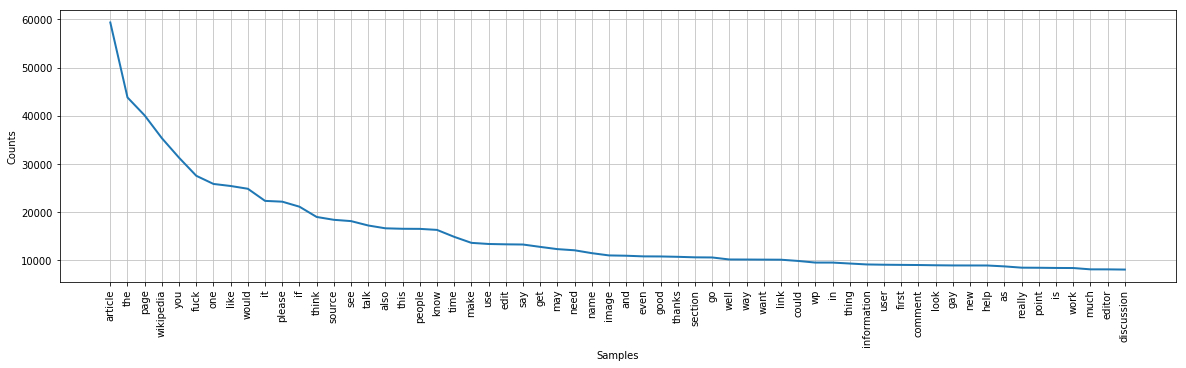

In [26]:
fdist_test_tt = showFreqDist(test_df_tt['tokens'])

##### Vocabulary size based on Wikipedia comments

In [27]:
print('Vocabulary size:')
vocab_tt = np.fromiter(fdist_train_tt.keys(),dtype=np.dtype(('U50', 1)))
vocab_wt = np.fromiter(fdist_train_wt.keys(),dtype=np.dtype(('U50', 1)))
vocab_test_tt = np.fromiter(fdist_test_tt.keys(),dtype=np.dtype(('U50', 1)))
vocab_tweet_tt = np.fromiter(fdist_tweet_tt.keys(),dtype=np.dtype(('U50', 1)))
print('Twitter Tokenizer: '+str(vocab_tt.shape[0]))
print('Word Tokenizer: '+str(vocab_wt.shape[0]))
print('Test vocab length after applying Twitter Tokenizer: '+str(vocab_test_tt.shape[0]))
print('Tweet vocab length after applying Twitter Tokenizer: '+str(vocab_tweet_tt.shape[0]))

Vocabulary size:
Twitter Tokenizer: 163279
Word Tokenizer: 169130
Test vocab length after applying Twitter Tokenizer: 219608
Tweet vocab length after applying Twitter Tokenizer: 207297


It looks like a lot of apostrphied words have been considered as seperate tokens in word tokenization while a word like "don't" is still considered as a complete word in twitter tokensization. There are about 177k words in the vocabulary from either tokenization menthod.

In [28]:
print('There is a difference of '+str(np.setdiff1d(vocab_test_tt,vocab_tt).shape[0])+' words between train and test data')

There is a difference of 144386 words between train and test data


In [29]:
print('Overall vocabulary length using unique words from train and test data is '
+str(len(set(np.append(vocab_test_tt,vocab_tt))))+' words')

Overall vocabulary length using unique words from train and test data is 307656 words


In [30]:
print('Overall vocabulary length using unique words from Wikipedia train, tweet and test data is '
+str(len(set(
    np.append(np.append(vocab_test_tt,vocab_tt),vocab_tweet_tt)
)))+' words')

Overall vocabulary length using unique words from Wikipedia train, tweet and test data is 458864 words


# 3. Converting tokens into feature vector

Word Embedding is a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions. Word embeddings can be generated using various methods like neural networks, co-occurrence matrix, probabilistic models, etc.

### 3.1 Bag of Word

In [31]:
def w2v(tokens, epochs, min_count,vector_size,window_size,sg,model_name):
    model = Word2Vec(tokens, iter = epochs, min_count=min_count,size=vector_size,window=window_size,sg=sg)
    model.save(model_name)
    return model

In [32]:
w2v_accuracy_df = pd.read_csv('w2v_accuracy.csv')
category_LIST = w2v_accuracy_df['category'].unique()
model_accuracy_df = pd.DataFrame()
model_accuracy_df['category'] = category_LIST
def check_we_accuracy(model,model_name):
    model_comparison = model.wv.accuracy('w2v_accuracy.txt')
    accuracy = []
    for category_LIST_ITEM in category_LIST:
        c = len(model_comparison[np.where(category_LIST == category_LIST_ITEM)[0][0]]['correct'])
        ic = len(model_comparison[np.where(category_LIST == category_LIST_ITEM)[0][0]]['incorrect'])
        accuracy.append(round(100*c/(c+ic),2))
    model_accuracy_df[model_name] = accuracy

In [33]:
#tweet_df_tt = tweet_df_tt.drop(['Unnamed: 0'],axis=1)
tweet_df_tt1 = tweet_df_tt.drop(['tweet','is_retweet','len','date','source','likes','retweets','screenname','followers','sentiment'],axis=1)
tweet_df_tt1['toxic'] = 0
tweet_df_tt1['severe_toxic'] = 0
tweet_df_tt1['obscene'] = 0
tweet_df_tt1['threat'] = 0
tweet_df_tt1['insult'] = 0
tweet_df_tt1['identity_hate'] = 0
tweet_df_tt1['all comments'] = 0
tweet_df_tt1.head()

,Unnamed: 0,id,comment_text,length,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate,all comments
2,2.0,8.496330e+17,lol nah it ain' that serious. honestly just l...,10.0,"[lol, nah, serious, honestly, like, pissed, du...",0,0,0,0,0,0,0
3,3.0,8.496320e+17,just another bitter Duke fan waiting for the ...,8.0,"[another, bitter, duke, fan, waiting, season, ...",0,0,0,0,0,0,0
4,4.0,8.496320e+17,"actually, no. Someone told me should see beca...",9.0,"[actually, someone, told, see, coward, like, k...",0,0,0,0,0,0,0
5,5.0,8.496220e+17,and? Who gone stop me?,3.0,"[who, gone, stop]",0,0,0,0,0,0,0
6,6.0,8.471380e+17,"actually, was on campus about month ago",4.0,"[actually, campus, month, ago]",0,0,0,0,0,0,0


In [34]:
train_df_tt['type']='Train'
test_df_tt['type']='Test'
tweet_df_tt1['type']='Tweet'
data_df1 = train_df_tt.append(test_df_tt, sort=False)
data_df = data_df1.append(tweet_df_tt1, sort=False)

##### CBOW Model 1-5

In [87]:
model1 = w2v(data_df['tokens'], 10, 1, 200, 5, 0, 'model1.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [88]:
check_we_accuracy(model1,'model1.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [91]:
model2 = w2v(data_df['tokens'], 20, 1, 200, 5, 0, 'model2.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [92]:
check_we_accuracy(model2,'model2.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [93]:
model3 = w2v(data_df['tokens'], 10, 1, 200, 15, 0, 'model3.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [94]:
check_we_accuracy(model3,'model3.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [95]:
model4 = w2v(data_df['tokens'], 10, 1, 300, 15, 0, 'model4.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [96]:
check_we_accuracy(model4,'model4.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [97]:
model5 = w2v(data_df['tokens'], 10, 2, 300, 15, 0, 'model5.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [98]:
check_we_accuracy(model5,'model5.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##### Ngram model 5-14

In [99]:
model6 = w2v(data_df['tokens'], 10, 1, 200, 5, 1, 'model6.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [100]:
check_we_accuracy(model6,'model6.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [108]:
model7 = w2v(data_df['tokens'], 20, 2, 200, 10, 1, 'model7.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [109]:
check_we_accuracy(model7,'model7.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [110]:
model8 = w2v(data_df['tokens'], 10, 2, 200, 15, 1, 'model8.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [111]:
check_we_accuracy(model8,'model8.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [116]:
model9 = w2v(data_df['tokens'], 20, 1, 200, 15, 1, 'model9.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [117]:
check_we_accuracy(model9,'model9.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [118]:
model10 = w2v(data_df['tokens'], 20, 2, 200, 15, 1, 'model10.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [119]:
check_we_accuracy(model10,'model10.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [120]:
model11 = w2v(data_df['tokens'], 20, 1, 300, 15, 1, 'model11.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [121]:
check_we_accuracy(model11,'model11.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [126]:
model12 = w2v(data_df['tokens'], 20, 1, 100, 15, 1, 'model12.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [127]:
check_we_accuracy(model12,'model12.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [128]:
model13 = w2v(data_df['tokens'], 20, 2, 300, 15, 1, 'model13.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [129]:
check_we_accuracy(model13,'model13.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [133]:
model14 = w2v(data_df['tokens'], 20, 5, 200, 15, 1, 'model14.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [134]:
check_we_accuracy(model14,'model14.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##### Load Google News Trained model

In [136]:
# Load Google's pre-trained Word2Vec model.
model_gn = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [174]:
check_we_accuracy(model_gn,'model_gn.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##### Load Keras IMDB review data and vectorise the tokens using Ngram

In [35]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data()
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:v+3 for k,v in word_to_id.items()}
id_to_word = {value:key for key,value in word_to_id.items()}
id_to_word[0]=''
id_to_word[1]=''
id_to_word[2]=''
imdb_df = pd.DataFrame()
comment = []
for X_train_ITEM in X_train:
     comment.append(' '.join(id_to_word[id] for id in X_train_ITEM))
imdb_df['comment_text'] = comment
imdb_df['toxic'] = Y_train

In [36]:
imdb_df_tt = myTokenizer(imdb_df, "TweetTokenizer")
imdb_df_tt = imdb_df_tt[imdb_df_tt['length']!=0]
imdb_df_tt = imdb_df_tt[imdb_df_tt.notna()]
imdb_df_tt['length'].describe()

count    25000.000000
mean       120.744120
std         91.496229
min          4.000000
25%         64.000000
50%         89.000000
75%        147.000000
max       1427.000000
Name: length, dtype: float64

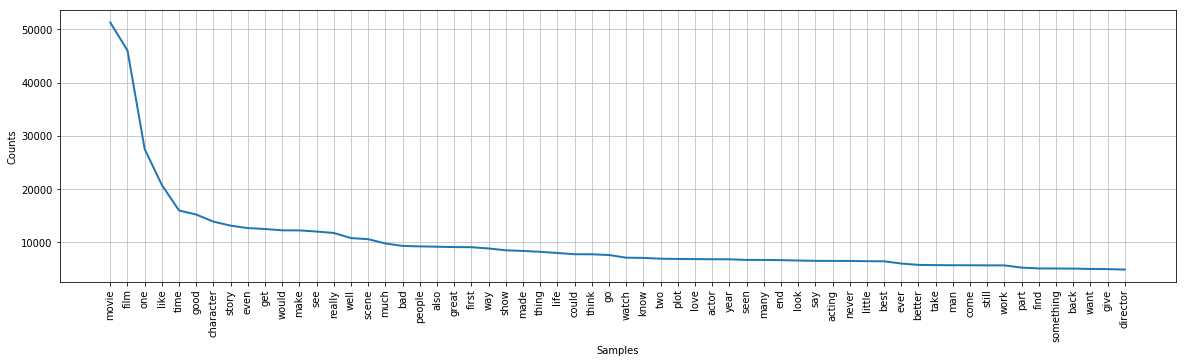

In [37]:
fdist_imdb_tt = showFreqDist(imdb_df_tt['tokens'])

In [38]:
data_imdb_df = data_df.append(imdb_df_tt, sort=False)

In [ ]:
model15_imdb = w2v(data_imdb_df['tokens'], 20, 2, 200, 15, 1, 'model15_imdb.bin')

In [199]:
check_we_accuracy(model15_imdb,'model15_imdb.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##### Load More Random Tweets

In [39]:
more_tweet_df = pd.read_csv('MoreTweets.csv')
more_tweet_df.head()

,Id,comment_text
0,1467810672,is upset that he can't update his Facebook by ...
1,1467810917,@Kenichan I dived many times for the ball. Man...
2,1467811184,my whole body feels itchy and like its on fire
3,1467811193,"@nationwideclass no, it's not behaving at all...."
4,1467811372,@Kwesidei not the whole crew


In [40]:
more_tweet_df_tt = myTokenizer(more_tweet_df, "TweetTokenizer")
more_tweet_df_tt = more_tweet_df_tt[more_tweet_df_tt['length']!=0]
more_tweet_df_tt = more_tweet_df_tt[more_tweet_df_tt.notna()]
more_tweet_df_tt['length'].describe()

count    530888.000000
mean          8.328467
std           4.562368
min           1.000000
25%           5.000000
50%           8.000000
75%          11.000000
max         208.000000
Name: length, dtype: float64

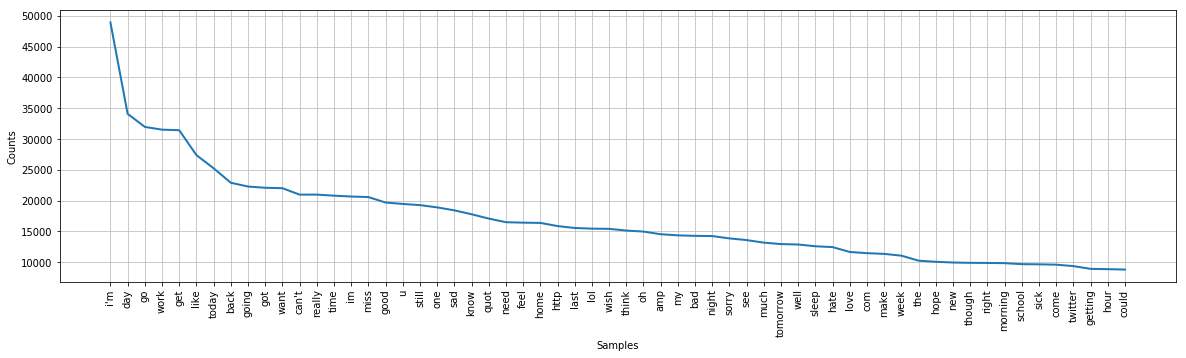

In [41]:
fdist_more_tweet_tt = showFreqDist(more_tweet_df_tt['tokens'])

In [42]:
data_more_tweet_df = data_imdb_df.append(more_tweet_df_tt, sort=False)

In [308]:
model16_moretweets = w2v(data_more_tweet_df['tokens'], 20, 2, 200, 15, 1, 'model16_moretweets.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [309]:
check_we_accuracy(model16_moretweets,'model16_moretweets.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##### Accuracy of the models
Model15 provide a better accuracy in the similar word test and is much closer to the Google news trained corpus than any other word2vec model

In [43]:
#Model_LIST = ['model1.bin','model2.bin','model3.bin','model4.bin','model5.bin','model6.bin','model7.bin','model8.bin',
              #'model9.bin','model10.bin','mdel11.bin','model12.bin','model13.bin','model14.bin','model_gn.bin',
              #'model15_imdb.bin','model16_moretweets.bin']

model1 = Word2Vec.load('model1.bin')
model2 = Word2Vec.load('model2.bin')
model3 = Word2Vec.load('model3.bin')
model4 = Word2Vec.load('model4.bin')
model5 = Word2Vec.load('model5.bin')
model6 = Word2Vec.load('model6.bin')
model7 = Word2Vec.load('model7.bin')
model8 = Word2Vec.load('model8.bin')
model9 = Word2Vec.load('model9.bin')
model10 = Word2Vec.load('model10.bin')
model11 = Word2Vec.load('model11.bin')
model12 = Word2Vec.load('model12.bin')
model13 = Word2Vec.load('model13.bin')
model14 = Word2Vec.load('model14.bin')
model15_imdb = Word2Vec.load('model15.bin')
model16_moretweets = Word2Vec.load('model16_moretweets.bin')

/Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [310]:
model_accuracy_df

,category,model1.bin,model2.bin,model3.bin,model4.bin,model5.bin,model6.bin,model7.bin,model8.bin,model9.bin,model10.bin,model11.bin,model12.bin,model13.bin,model14.bin,model_gn.bin,model15_imdb.bin,model16_moretweets.bin
0,capital-common-countries,31.05,38.16,37.37,33.95,38.16,26.32,50.00,53.95,55.53,60.00,52.89,50.00,58.68,54.74,83.60,63.42,73.57
1,capital-world,23.41,28.21,29.65,30.13,33.85,19.93,42.98,45.50,47.18,49.34,47.54,38.06,48.50,46.22,82.72,53.30,53.58
2,currency,1.16,2.33,2.33,2.33,3.49,0.00,0.00,0.00,0.00,1.16,0.00,3.49,0.00,0.00,39.84,0.00,0.00
3,city-in-state,10.58,12.72,23.67,30.09,25.81,14.25,33.94,26.54,31.99,32.72,37.00,24.53,32.84,34.80,74.64,35.79,33.47
4,family,66.01,68.95,69.28,69.93,73.20,58.50,37.25,41.18,42.48,41.83,52.61,28.76,41.83,41.18,90.06,47.66,54.97
5,gram1-adjective-to-adverb,7.14,10.22,9.48,7.14,6.40,5.67,6.65,5.17,4.19,7.02,4.06,4.68,5.17,6.16,32.27,8.37,8.25
6,gram2-opposite,17.00,20.83,16.67,15.33,16.17,14.17,11.00,11.83,7.67,10.83,7.17,8.00,7.33,7.17,50.53,9.40,10.26
7,gram3-comparative,55.32,57.38,39.76,44.21,47.14,40.40,27.78,24.13,19.84,20.16,20.95,24.05,18.41,19.37,91.89,27.78,33.73
8,gram4-superlative,32.07,38.39,28.85,28.74,22.07,20.23,12.18,10.57,9.89,7.36,7.59,9.77,7.24,8.28,88.03,15.15,13.23
9,gram5-present-participle,54.30,54.73,54.95,53.33,50.54,47.53,42.80,39.14,40.32,42.04,37.20,34.19,37.31,39.46,79.77,40.83,48.49


# 4. Prepare data for embedding Layer

### 4.1  Word2Vec Model 16 with ~500,000 Additional Random Tweet used for Word Embedding model

In [44]:
vocab = model16_moretweets.wv.index2entity
index_to_word = dict()
i = 1
for word in vocab:
    index_to_word[i] = word
    i = i + 1
word_to_index = {w:v for v,w in index_to_word.items()}

In [45]:
def int_token(data, max_len, word_to_index):
    tokens = np.array(data['tokens'])
    sent_len = np.array(data['length'])
    tokens_trunc = [sent[:max_len] for sent in tokens]

    int_token = []
    count = 0
    for tokens_trunc_ITEM in tokens_trunc:
        int_sent = []
        for word in tokens_trunc_ITEM:
            try: 
                int_sent.append(word_to_index[word])
            except:
                int_sent.append(0)
        int_token.append(int_sent)
        count = count + 1
    return int_token

##### Max words per comment = 100

In [46]:
data_more_tweet_df['int_token']=int_token(data_more_tweet_df, 100, word_to_index)

In [47]:
embedding_matrix=[]
for w,v in word_to_index.items():
    embedding_matrix.append(model16_moretweets.wv[w])
print(str(len(embedding_matrix))+' words embedded for training')
maxlen = 100
embedding_matrix = np.array(embedding_matrix)

264640 words embedded for training


In [48]:
X_train_pad = pad_sequences(np.array(data_more_tweet_df[data_more_tweet_df['type']=='Train']['int_token']), 
                            maxlen=maxlen)
X_test_pad = pad_sequences(np.array(data_more_tweet_df[data_more_tweet_df['type']=='Test']['int_token']), 
                            maxlen=maxlen)
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = data_more_tweet_df[data_more_tweet_df['type']=='Train'][list_classes]
y = np.array(round(y,0))

##### CNN Model with multiple 1D conv layer and shallow dense layer

In [52]:
inp4 = Input(shape=(maxlen, ))
x4 = Embedding(len(word_to_index), len(embedding_matrix[0]),weights=[embedding_matrix],trainable=False)(inp4)
x4 = Conv1D(128, 5, activation='relu')(x4)
x4 = MaxPooling1D()(x4)
x4 = Conv1D(512, 7, activation='relu')(x4)
x4 = MaxPooling1D()(x4)
x4 = Conv1D(256, 3, activation='relu')(x4)
x4 = MaxPooling1D()(x4)
x4 = Dropout(0.1)(x4)
x4 = Flatten()(x4)
x4 = Dense(128, activation="relu")(x4)
x4 = Dropout(0.1)(x4)
x4 = Dense(64, activation="relu")(x4)
x4 = Dropout(0.1)(x4)
x4 = Dense(6, activation="sigmoid")(x4)
model4 = Model(inputs=inp4, outputs=x4)
model4.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 200)          52928000  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 96, 128)           128128    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 42, 512)           459264    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 21, 512)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 19, 256)           393472    
__________

In [53]:
batch_size = 32
epochs = 3
hist4 = model4.fit(X_train_pad,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143578 samples, validate on 15954 samples
Epoch 1/3
143578/143578 [==============================] - 682s 5ms/step - loss: 0.1255 - acc: 0.9661 - val_loss: 0.1122 - val_acc: 0.9686
Epoch 2/3
143578/143578 [==============================] - 668s 5ms/step - loss: 0.1023 - acc: 0.9706 - val_loss: 0.1008 - val_acc: 0.9704
Epoch 3/3
143578/143578 [==============================] - 648s 5ms/step - loss: 0.0940 - acc: 0.9721 - val_loss: 0.0998 - val_acc: 0.9701


In [54]:
y_pred4 = model4.predict(X_test_pad)

In [57]:
test_data = data_more_tweet_df[data_more_tweet_df['type']=='Test'].drop(['Unnamed: 0', 'Id'], axis=1)
test_data = test_data.reset_index(drop=True).drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
test_pred_df = pd.DataFrame(data=np.round(y_pred4,0), columns=['toxic_pred','severe_toxic_pred','obscene_pred','threat_pred','insult_pred','identity_hate_pred'])
test_df = pd.concat([test_data,test_pred_df], axis=1, sort=False)
test_label_df = pd.read_csv('test_labels.csv')
test_result = pd.merge(test_label_df, test_df, how='inner', on = 'id')

In [58]:
data = test_result[test_result['toxic']!=-1]
field_LIST = [['toxic_pred','toxic'],
['severe_toxic_pred','severe_toxic'],
['obscene_pred','obscene'],
['threat_pred','threat'],
['insult_pred','insult'],
['identity_hate_pred','identity_hate']]

for field_LIST_ITEM in field_LIST:
    print(field_LIST_ITEM[1]+'\n')
    try:
        print('N = '+str(len(data[(data[field_LIST_ITEM[0]]==1)])))
        TP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==1)])
        FP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==0)])
        TN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==0)])
        FN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==1)])
        P = TP/(TP+FP)
        A = (TP+TN)/(TP+TN+FP+FN)
        R = TP/(TP+FN)
        print('Precission = '+str(round(P*100,2))+'%')
        print('Accuracy = '+str(round(A*100,2))+'%')
        print('Recall = '+str(round(R*100,2))+'%\n\n')
    except:
        print('No records for the following category '+field_LIST_ITEM[0]+'\n\n')

toxic

N = 3406
Precission = 53.35%
Accuracy = 90.83%
Recall = 29.85%


severe_toxic

N = 42
Precission = 50.0%
Accuracy = 99.43%
Recall = 5.72%


obscene

N = 2202
Precission = 56.77%
Accuracy = 94.69%
Recall = 33.88%


threat

N = 0
No records for the following category threat_pred


insult

N = 1985
Precission = 52.8%
Accuracy = 94.81%
Recall = 30.6%


identity_hate

N = 0
No records for the following category identity_hate_pred




##### Vanila LSTM with 60 hidden Layer

In [302]:
inp1 = Input(shape=(maxlen, ))
x1 = Embedding(len(word_to_index), len(embedding_matrix[0]),weights=[embedding_matrix],trainable=False)(inp1)
x1 = LSTM(60, return_sequences=True,name='lstm_layer')(x1)
#x1 = TimeDistributed(Dense(6))(x1)
x1 = Flatten()(x1)
x1 = Dense(6, activation="sigmoid")(x1)
model1 = Model(inputs=inp1, outputs=x1)
model1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 100, 200)          52928000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 100, 60)           62640     
_________________________________________________________________
flatten_2 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 36006     
Total params: 53,026,646
Trainable params: 98,646
Non-trainable params: 52,928,000
_________________________________________________________________


In [298]:
z = y.reshape(159532, 6, 1)
y.shape

(159532, 6)

In [303]:
batch_size = 32
epochs = 3
hist1 = model1.fit(X_train_pad,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143578 samples, validate on 15954 samples
Epoch 1/3
143578/143578 [==============================] - 505s 4ms/step - loss: 0.0964 - acc: 0.9719 - val_loss: 0.0765 - val_acc: 0.9756
Epoch 2/3
143578/143578 [==============================] - 471s 3ms/step - loss: 0.0660 - acc: 0.9787 - val_loss: 0.0662 - val_acc: 0.9782
Epoch 3/3
143578/143578 [==============================] - 465s 3ms/step - loss: 0.0551 - acc: 0.9812 - val_loss: 0.0599 - val_acc: 0.9795


In [304]:
y_pred1 = model1.predict(X_test_pad)
#y_pred = np.round(y_pred,0)

In [305]:
test_data = data_more_tweet_df[data_more_tweet_df['type']=='Test'].drop(['Unnamed: 0', 'Id'], axis=1)
test_data = test_data.reset_index(drop=True).drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
test_pred_df = pd.DataFrame(data=np.round(y_pred1,0), columns=['toxic_pred','severe_toxic_pred','obscene_pred','threat_pred','insult_pred','identity_hate_pred'])
test_df = pd.concat([test_data,test_pred_df], axis=1, sort=False)
test_label_df = pd.read_csv('test_labels.csv')
test_result = pd.merge(test_label_df, test_df, how='inner', on = 'id')

In [306]:
data = test_result[test_result['toxic']!=-1]
field_LIST = [['toxic_pred','toxic'],
['severe_toxic_pred','severe_toxic'],
['obscene_pred','obscene'],
['threat_pred','threat'],
['insult_pred','insult'],
['identity_hate_pred','identity_hate']]

for field_LIST_ITEM in field_LIST:
    print(field_LIST_ITEM[1]+'\n')
    try:
        print('N = '+str(len(data[(data[field_LIST_ITEM[0]]==1)])))
        TP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==1)])
        FP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==0)])
        TN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==0)])
        FN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==1)])
        P = TP/(TP+FP)
        A = (TP+TN)/(TP+TN+FP+FN)
        R = TP/(TP+FN)
        print('Precission = '+str(round(P*100,2))+'%')
        print('Accuracy = '+str(round(A*100,2))+'%')
        print('Recall = '+str(round(R*100,2))+'%\n\n')
    except:
        print('No records for the following category '+field_LIST_ITEM[0]+'\n\n')

toxic

N = 7338
Precission = 59.87%
Accuracy = 92.74%
Recall = 72.16%


severe_toxic

N = 487
Precission = 33.06%
Accuracy = 99.17%
Recall = 43.87%


obscene

N = 3930
Precission = 64.86%
Accuracy = 96.05%
Recall = 69.1%


threat

N = 50
Precission = 36.0%
Accuracy = 99.65%
Recall = 8.53%


insult

N = 3359
Precission = 61.89%
Accuracy = 95.89%
Recall = 60.7%


identity_hate

N = 385
Precission = 48.05%
Accuracy = 98.86%
Recall = 25.98%




##### Bidirectional LSTM with Reccurrent dropouts and pooling Layer

In [79]:
inp = Input(shape=(maxlen, ))
x = Embedding(len(word_to_index), len(embedding_matrix[0]),weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

W0803 13:38:28.578186 4425434560 deprecation.py:506] From /Users/anishphilljoe/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [80]:
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [82]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 200)          52928000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 120)          125280    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [ ]:
batch_size = 32
epochs = 3
hist = model.fit(X_train_pad,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [126]:
y_pred = model.predict(X_test_pad)
#y_pred = np.round(y_pred,0)

In [247]:
test_data = data_more_tweet_df[data_more_tweet_df['type']=='Test'].drop(['Unnamed: 0', 'Id'], axis=1)
test_data = test_data.reset_index(drop=True).drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
test_pred_df = pd.DataFrame(data=np.round(y_pred,0), columns=['toxic_pred','severe_toxic_pred','obscene_pred','threat_pred','insult_pred','identity_hate_pred'])
test_df = pd.concat([test_data,test_pred_df], axis=1, sort=False)
test_label_df = pd.read_csv('test_labels.csv')
test_result = pd.merge(test_label_df, test_df, how='inner', on = 'id')


In [257]:
data = test_result[test_result['toxic']!=-1]
field_LIST = [['toxic_pred','toxic'],
['severe_toxic_pred','severe_toxic'],
['obscene_pred','obscene'],
['threat_pred','threat'],
['insult_pred','insult'],
['identity_hate_pred','identity_hate']]

for field_LIST_ITEM in field_LIST:
    print(field_LIST_ITEM[1]+'\n')
    try:
        print('N = '+str(len(data[(data[field_LIST_ITEM[0]]==1)])))
        TP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==1)])
        FP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==0)])
        TN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==0)])
        FN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==1)])
        #print("TP: "+str(TP))
        #print("FP: "+str(FP))
        #print("TN: "+str(TN))
        #print("FN: "+str(FN))
        #print('Total test records: '+str(len(data)))
        P = TP/(TP+FP)
        A = (TP+TN)/(TP+TN+FP+FN)
        R = TP/(TP+FN)
        print('Precission = '+str(round(P*100,2))+'%')
        print('Accuracy = '+str(round(A*100,2))+'%')
        print('Recall = '+str(round(R*100,2))+'%\n\n')
    except:
        print('No records for the following category '+field_LIST_ITEM[0]+'\n\n')

toxic

N = 7523
Precission = 59.94%
Accuracy = 92.81%
Recall = 74.06%


severe_toxic

N = 258
Precission = 41.09%
Accuracy = 99.35%
Recall = 28.88%


obscene

N = 3794
Precission = 66.63%
Accuracy = 96.2%
Recall = 68.53%


threat

N = 0
No records for the following category threat_pred


insult

N = 3172
Precission = 64.0%
Accuracy = 96.03%
Recall = 59.27%


identity_hate

N = 77
Precission = 87.01%
Accuracy = 98.97%
Recall = 9.41%




##### Bidirectional LSTM with 1D Conv Layer with deep dense layer

In [321]:
inp2 = Input(shape=(maxlen, ))
x2 = Embedding(len(word_to_index), len(embedding_matrix[0]),weights=[embedding_matrix],trainable=False)(inp2)
x2 = Bidirectional(LSTM(90, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x2)
x2 = Conv1D(128, 5, activation='relu')(x2)
x2 = GlobalMaxPool1D()(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(100, activation="relu")(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(50, activation="relu")(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(6, activation="sigmoid")(x2)
model2 = Model(inputs=inp2, outputs=x2)
model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 100, 200)          52928000  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100, 180)          209520    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           115328    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               12900     
__________

In [322]:
batch_size = 32
epochs = 3
hist2 = model2.fit(X_train_pad,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143578 samples, validate on 15954 samples
Epoch 1/3
143578/143578 [==============================] - 1341s 9ms/step - loss: 0.0900 - acc: 0.9742 - val_loss: 0.0673 - val_acc: 0.9779
Epoch 2/3
143578/143578 [==============================] - 1003s 7ms/step - loss: 0.0611 - acc: 0.9800 - val_loss: 0.0573 - val_acc: 0.9801
Epoch 3/3
143578/143578 [==============================] - 906s 6ms/step - loss: 0.0524 - acc: 0.9816 - val_loss: 0.0568 - val_acc: 0.9812


In [327]:
y_pred2 = model2.predict(X_test_pad)

In [338]:
test_data = data_more_tweet_df[data_more_tweet_df['type']=='Test'].drop(['Unnamed: 0', 'Id'], axis=1)
test_data = test_data.reset_index(drop=True).drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
test_pred_df = pd.DataFrame(data=np.round(y_pred2,0), columns=['toxic_pred','severe_toxic_pred','obscene_pred','threat_pred','insult_pred','identity_hate_pred'])
test_df = pd.concat([test_data,test_pred_df], axis=1, sort=False)
test_label_df = pd.read_csv('test_labels.csv')
test_result = pd.merge(test_label_df, test_df, how='inner', on = 'id')

In [339]:
data = test_result[test_result['toxic']!=-1]
field_LIST = [['toxic_pred','toxic'],
['severe_toxic_pred','severe_toxic'],
['obscene_pred','obscene'],
['threat_pred','threat'],
['insult_pred','insult'],
['identity_hate_pred','identity_hate']]

for field_LIST_ITEM in field_LIST:
    print(field_LIST_ITEM[1]+'\n')
    try:
        print('Predicted N = '+str(len(data[(data[field_LIST_ITEM[0]]==1)])))
        print('Actual N = '+str(len(data[(data[field_LIST_ITEM[1]]==1)])))
        TP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==1)])
        FP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==0)])
        TN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==0)])
        FN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==1)])
        P = TP/(TP+FP)
        A = (TP+TN)/(TP+TN+FP+FN)
        R = TP/(TP+FN)
        print('Precission = '+str(round(P*100,2))+'%')
        print('Accuracy = '+str(round(A*100,2))+'%')
        print('Recall = '+str(round(R*100,2))+'%\n\n')
    except:
        print('No records for the following category '+field_LIST_ITEM[0]+'\n\n')

toxic

Predicted N = 7150
Actual N = 6088
Precission = 61.72%
Accuracy = 93.09%
Recall = 72.49%


severe_toxic

Predicted N = 100
Actual N = 367
Precission = 57.0%
Accuracy = 99.45%
Recall = 15.53%


obscene

Predicted N = 4311
Actual N = 3689
Precission = 62.31%
Accuracy = 95.89%
Recall = 72.81%


threat

Predicted N = 0
Actual N = 211
No records for the following category threat_pred


insult

Predicted N = 2938
Actual N = 3425
Precission = 68.41%
Accuracy = 96.33%
Recall = 58.69%


identity_hate

Predicted N = 19
Actual N = 712
Precission = 89.47%
Accuracy = 98.91%
Recall = 2.39%




### 4.2 Word2Vec Model 15 with ~500,000 Additional IMDB Movie Reviews used for Word Embedding model

In [323]:
vocab = model15_imdb.wv.index2entity
index_to_word = dict()
i = 1
for word in vocab:
    index_to_word[i] = word
    i = i + 1
word_to_index = {w:v for v,w in index_to_word.items()}

In [324]:
data_imdb_df['int_token']=int_token(data_imdb_df, 100, word_to_index)

In [325]:
embedding_matrix=[]
for w,v in word_to_index.items():
    embedding_matrix.append(model15_imdb.wv[w])
print(str(len(embedding_matrix))+' words embedded for training')
maxlen = 100
embedding_matrix = np.array(embedding_matrix)

214087 words embedded for training


##### Rerun Bidirectional LSTM with multiple dense layers

In [332]:
inp3 = Input(shape=(maxlen, ))
x3 = Embedding(len(word_to_index), len(embedding_matrix[0]),weights=[embedding_matrix],trainable=False)(inp3)
x3 = Bidirectional(LSTM(90, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x3)
x3 = Dropout(0.1)(x3)
x3 = Dense(50, activation="relu")(x3)
x3 = Dropout(0.1)(x3)
x3 = Dense(100, activation="relu")(x3)
x3 = Dropout(0.1)(x3)
x3 = Dense(100, activation="relu")(x3)
x3 = Dropout(0.1)(x3)
x3 = Dense(50, activation="relu")(x3)
x3 = Dropout(0.1)(x3)
x3 = Flatten()(x3)
x3 = Dense(6, activation="sigmoid")(x3)
model3 = Model(inputs=inp3, outputs=x3)
model3.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 100, 200)          42817400  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 100, 180)          209520    
_________________________________________________________________
dropout_20 (Dropout)         (None, 100, 180)          0         
_________________________________________________________________
dense_47 (Dense)             (None, 100, 50)           9050      
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
dense_48 (Dense)             (None, 100, 100)          5100      
__________

In [333]:
batch_size = 32
epochs = 3
hist3 = model3.fit(X_train_pad,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143578 samples, validate on 15954 samples
Epoch 1/3
143578/143578 [==============================] - 939s 7ms/step - loss: 0.0932 - acc: 0.9730 - val_loss: 0.0698 - val_acc: 0.9771
Epoch 2/3
143578/143578 [==============================] - 956s 7ms/step - loss: 0.0625 - acc: 0.9795 - val_loss: 0.0674 - val_acc: 0.9788
Epoch 3/3
143578/143578 [==============================] - 1029s 7ms/step - loss: 0.0546 - acc: 0.9811 - val_loss: 0.0575 - val_acc: 0.9804


In [334]:
y_pred3 = model3.predict(X_test_pad)

In [344]:
test_data = data_more_tweet_df[data_more_tweet_df['type']=='Test'].drop(['Unnamed: 0', 'Id'], axis=1)
test_data = test_data.reset_index(drop=True).drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
test_pred_df = pd.DataFrame(data=np.round(y_pred3,0), columns=['toxic_pred','severe_toxic_pred','obscene_pred','threat_pred','insult_pred','identity_hate_pred'])
test_df = pd.concat([test_data,test_pred_df], axis=1, sort=False)
test_label_df = pd.read_csv('test_labels.csv')
test_result = pd.merge(test_label_df, test_df, how='inner', on = 'id')

In [345]:
data = test_result[test_result['toxic']!=-1]
field_LIST = [['toxic_pred','toxic'],
['severe_toxic_pred','severe_toxic'],
['obscene_pred','obscene'],
['threat_pred','threat'],
['insult_pred','insult'],
['identity_hate_pred','identity_hate']]

for field_LIST_ITEM in field_LIST:
    print(field_LIST_ITEM[1]+'\n')
    try:
        print('Predicted N = '+str(len(data[(data[field_LIST_ITEM[0]]==1)])))
        print('Actual N = '+str(len(data[(data[field_LIST_ITEM[1]]==1)])))
        TP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==1)])
        FP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==0)])
        TN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==0)])
        FN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==1)])
        P = TP/(TP+FP)
        A = (TP+TN)/(TP+TN+FP+FN)
        R = TP/(TP+FN)
        print('Precission = '+str(round(P*100,2))+'%')
        print('Accuracy = '+str(round(A*100,2))+'%')
        print('Recall = '+str(round(R*100,2))+'%\n\n')
    except:
        print('No records for the following category '+field_LIST_ITEM[0]+'\n\n')

toxic

Predicted N = 8954
Actual N = 6088
Precission = 55.28%
Accuracy = 91.95%
Recall = 81.31%


severe_toxic

Predicted N = 239
Actual N = 367
Precission = 40.17%
Accuracy = 99.35%
Recall = 26.16%


obscene

Predicted N = 5270
Actual N = 3689
Precission = 56.2%
Accuracy = 95.25%
Recall = 80.29%


threat

Predicted N = 0
Actual N = 211
No records for the following category threat_pred


insult

Predicted N = 4398
Actual N = 3425
Precission = 53.34%
Accuracy = 95.1%
Recall = 68.5%


identity_hate

Predicted N = 47
Actual N = 712
Precission = 63.83%
Accuracy = 98.91%
Recall = 4.21%




##### Stacked LSTM

In [62]:
inp5 = Input(shape=(maxlen, ))
x5 = Embedding(len(word_to_index), len(embedding_matrix[0]),weights=[embedding_matrix],trainable=False)(inp5)
x5 = LSTM(60, return_sequences=True,name='lstm_layer1',dropout=0.1,recurrent_dropout=0.1)(x5)
x5 = LSTM(60,name='lstm_layer2',dropout=0.1,recurrent_dropout=0.1)(x5)
x5 = Dropout(0.1)(x5)
x5 = Dense(50, activation="relu")(x5)
x5 = Dropout(0.1)(x5)
x5 = Dense(100, activation="relu")(x5)
x5 = Dropout(0.1)(x5)
x5 = Dense(50, activation="relu")(x5)
x5 = Dropout(0.1)(x5)
#x5 = Flatten()(x5)
x5 = Dense(6, activation="sigmoid")(x5)
model5 = Model(inputs=inp5, outputs=x5)
model5.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 200)          52928000  
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 100, 60)           62640     
_________________________________________________________________
lstm_layer2 (LSTM)           (None, 60)                29040     
_________________________________________________________________
dropout_20 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
__________

In [63]:
batch_size = 32
epochs = 3
hist5 = model5.fit(X_train_pad,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143578 samples, validate on 15954 samples
Epoch 1/3
143578/143578 [==============================] - 1027s 7ms/step - loss: 0.1052 - acc: 0.9703 - val_loss: 0.0760 - val_acc: 0.9765
Epoch 2/3
143578/143578 [==============================] - 1003s 7ms/step - loss: 0.0721 - acc: 0.9776 - val_loss: 0.0688 - val_acc: 0.9783
Epoch 3/3
143578/143578 [==============================] - 1010s 7ms/step - loss: 0.0627 - acc: 0.9793 - val_loss: 0.0604 - val_acc: 0.9797


In [64]:
y_pred5 = model5.predict(X_test_pad)

In [65]:
test_data = data_more_tweet_df[data_more_tweet_df['type']=='Test'].drop(['Unnamed: 0', 'Id'], axis=1)
test_data = test_data.reset_index(drop=True).drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'], axis=1)
test_pred_df = pd.DataFrame(data=np.round(y_pred5,0), columns=['toxic_pred','severe_toxic_pred','obscene_pred','threat_pred','insult_pred','identity_hate_pred'])
test_df = pd.concat([test_data,test_pred_df], axis=1, sort=False)
test_label_df = pd.read_csv('test_labels.csv')
test_result = pd.merge(test_label_df, test_df, how='inner', on = 'id')

In [66]:
data = test_result[test_result['toxic']!=-1]
field_LIST = [['toxic_pred','toxic'],
['severe_toxic_pred','severe_toxic'],
['obscene_pred','obscene'],
['threat_pred','threat'],
['insult_pred','insult'],
['identity_hate_pred','identity_hate']]

for field_LIST_ITEM in field_LIST:
    print(field_LIST_ITEM[1]+'\n')
    try:
        print('Predicted N = '+str(len(data[(data[field_LIST_ITEM[0]]==1)])))
        print('Actual N = '+str(len(data[(data[field_LIST_ITEM[1]]==1)])))
        TP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==1)])
        FP = len(data[(data[field_LIST_ITEM[0]]==1) & (data[field_LIST_ITEM[1]]==0)])
        TN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==0)])
        FN = len(data[(data[field_LIST_ITEM[0]]==0) & (data[field_LIST_ITEM[1]]==1)])
        P = TP/(TP+FP)
        A = (TP+TN)/(TP+TN+FP+FN)
        R = TP/(TP+FN)
        print('Precission = '+str(round(P*100,2))+'%')
        print('Accuracy = '+str(round(A*100,2))+'%')
        print('Recall = '+str(round(R*100,2))+'%\n\n')
    except:
        print('No records for the following category '+field_LIST_ITEM[0]+'\n\n')

toxic

Predicted N = 6735
Actual N = 6088
Precission = 63.22%
Accuracy = 93.26%
Recall = 69.94%


severe_toxic

Predicted N = 127
Actual N = 367
Precission = 47.24%
Accuracy = 99.41%
Recall = 16.35%


obscene

Predicted N = 3623
Actual N = 3689
Precission = 68.42%
Accuracy = 96.32%
Recall = 67.2%


threat

Predicted N = 0
Actual N = 211
No records for the following category threat_pred


insult

Predicted N = 2853
Actual N = 3425
Precission = 62.92%
Accuracy = 95.79%
Recall = 52.41%


identity_hate

Predicted N = 0
Actual N = 712
No records for the following category identity_hate_pred




# 5. Let's apply the best model so far to identify the negative tweets scraped from the official accounts of NBA Players

In [72]:
tweet_df_tt.head()

,Unnamed: 0,id,tweet,is_retweet,len,date,source,likes,retweets,screenname,followers,sentiment,comment_text,length,tokens
2,2.0,8.496330e+17,@CountryAssDot lol nah it ain't that serious. ...,False,128.0,2017-04-05 14:40:52,Echofon,1.0,1.0,hairston_pj,3149.0,1.0,lol nah it ain' that serious. honestly just l...,10.0,"[lol, nah, serious, honestly, like, pissed, du..."
3,3.0,8.496320e+17,@CountryAssDot just another bitter Duke fan wa...,False,89.0,2017-04-05 14:39:06,Echofon,4.0,1.0,hairston_pj,3149.0,1.0,just another bitter Duke fan waiting for the ...,8.0,"[another, bitter, duke, fan, waiting, season, ..."
4,4.0,8.496320e+17,"@CountryAssDot actually, no. Someone told me I...",False,107.0,2017-04-05 14:38:30,Echofon,1.0,1.0,hairston_pj,3149.0,0.0,"actually, no. Someone told me should see beca...",9.0,"[actually, someone, told, see, coward, like, k..."
5,5.0,8.496220e+17,@CountryAssDot and? Who gone stop me?,False,37.0,2017-04-05 13:57:54,Echofon,1.0,1.0,hairston_pj,3149.0,0.0,and? Who gone stop me?,3.0,"[who, gone, stop]"
6,6.0,8.471380e+17,"@AnkleJoelBerry actually, I was on campus abou...",False,61.0,2017-03-29 17:27:41,Echofon,0.0,0.0,hairston_pj,3149.0,0.0,"actually, was on campus about month ago",4.0,"[actually, campus, month, ago]"
